#0. 라이브러리 임포트

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from google.colab import drive
from tensorflow.keras.applications import MobileNet

In [2]:
import re
import subprocess
from pathlib import Path
from typing import List, Optional

# import openvino as ov
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

# import nncf

#1. 데이터 로딩 및 라벨링

In [3]:
# 코랩 파일 마운트
drive.mount('/content/drive')

def loadfile(path):
    X = []
    Y = []

    for label in ('danger_key', 'danger', 'danger_st', 'danger_wi','normal' ,'warnning_both','warnning_leaf','warnning_sq') :
        print("Loading training images for the label: " + label)

        for filename in os.listdir(path + label + "/"):
            img = cv2.imread(path + label + "/" + filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            img[:,:,0] = cv2.equalizeHist(img[:,:,0])
            img = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)
            img = cv2.resize(img, (224, 224))
            X.append(img)
            if label == 'danger':
                Y.append(0)
            elif label == 'danger_key':
                Y.append(1)
            elif label == 'danger_st':
                Y.append(2)
            elif label == 'danger_wi':
                Y.append(3)
            elif label == 'normal':
                Y.append(4)
            elif label == 'warnning_sq':
                Y.append(5)
            elif label == 'warnning_leaf':
                Y.append(6)
            elif label == 'warnning_both':
                Y.append(7)


    X = np.array(X)
    Y = np.array(Y)

    return X, Y


Mounted at /content/drive


# 2. 데이터전처리
 - Train/Test/Validaion Split,
 - Normalization
 - Data Augmentation

In [4]:
# 데이터 불러오기
X, y = loadfile('/content/drive/MyDrive/data/')

# Train : Val = 0.7 : 0.3로 데이터 세트 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# 정규화
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

# 데이터 증강
# 회전범위 증가(20-40),전단변화 추가, 줌 추가
datagen = ImageDataGenerator(
    rotation_range=40,  # 회전 범위 증가
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  # 전단 변환 추가
    zoom_range=0.2,  # 줌 추가
    horizontal_flip=True,
    fill_mode='nearest'  # 새로 생성된 픽셀을 채우는 방법
)

# Compute quantities required for featurewise normalization
datagen.fit(X_train)

Loading training images for the label: danger_key
Loading training images for the label: danger
Loading training images for the label: danger_st
Loading training images for the label: danger_wi
Loading training images for the label: normal
Loading training images for the label: warnning_both
Loading training images for the label: warnning_leaf
Loading training images for the label: warnning_sq


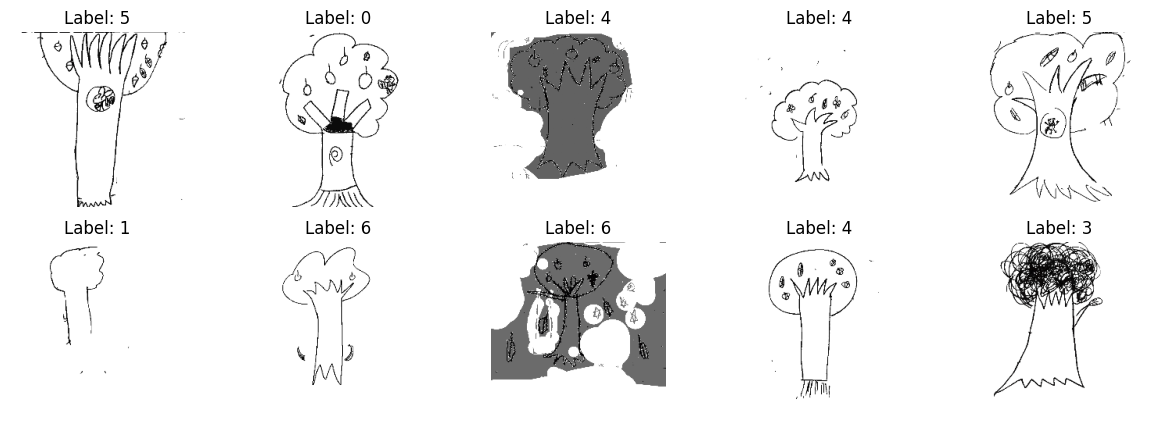

In [5]:
# 전처리 된 후 이미지 샘플 랜덤으로 10장 확인

import random
import matplotlib.pyplot as plt

sample_images = random.sample(range(len(X_train)), 10)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(sample_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.show()


# 3. 모델링
 - Resnet Import
 - Model Summary
 - Epoch

In [6]:
# early stopping activating,

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Build a simple ResNet50-based model
model = Sequential()
model.add(ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg'))
model.add(Dropout(0.5))  # 드롭아웃 추가
model.add(Dense(8, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 5s 0us/step


In [7]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 23550984 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 모델 체크포인트 콜백 설정
checkpoint = ModelCheckpoint('best_model_resnet_tree.h5', monitor='val_loss', save_best_only=True, verbose=1)

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=90, verbose=1)

# 모델 훈련
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    steps_per_epoch=len(X_train) / 16,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]  # 콜백 추가
)


Epoch 1/100
38/37 [==============================] - ETA: 0s - loss: 2.0282 - accuracy: 0.3055
Epoch 1: val_loss improved from inf to 66.58551, saving model to best_model_resnet_tree.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 69s 663ms/step - loss: 2.0282 - accuracy: 0.3055 - val_loss: 66.5855 - val_accuracy: 0.0194
Epoch 2/100
38/37 [==============================] - ETA: 0s - loss: 1.6167 - accuracy: 0.4157
Epoch 2: val_loss improved from 66.58551 to 2.60062, saving model to best_model_resnet_tree.h5
37/37 [==============================] - 13s 327ms/step - loss: 1.6167 - accuracy: 0.4157 - val_loss: 2.6006 - val_accuracy: 0.2481
Epoch 3/100
38/37 [==============================] - ETA: 0s - loss: 1.3269 - accuracy: 0.5326
Epoch 3: val_loss improved from 2.60062 to 1.85457, saving model to best_model_resnet_tree.h5
37/37 [==============================] - 14s 360ms/step - loss: 1.3269 - accuracy: 0.5326 - val_loss: 1.8546 - val_accuracy: 0.2481
Epoch 4/100
38/37 [==============================] - ETA: 0s - loss: 1.1319 - accuracy: 0.6344
Epoch 4: val_loss did not improve from 1.85457
37/37 [==============================] - 12s 313ms/step - loss: 1.1319 - accuracy:

# 평가지표 확인

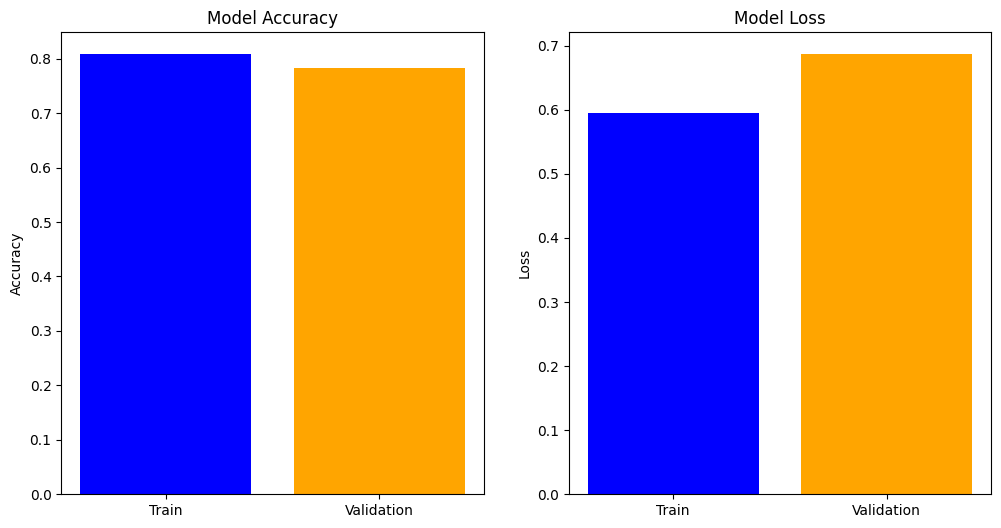

In [9]:
from tensorflow.keras.models import load_model

# 최고 성능 모델 불러오기
best_model = load_model('best_model_resnet_tree.h5')

# 훈련 데이터와 검증 데이터에 대한 성능 평가
train_loss, train_accuracy = best_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=0)

# 성능 시각화
plt.figure(figsize=(12, 6))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.bar(['Train', 'Validation'], [train_accuracy, val_accuracy], color=['blue', 'orange'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')

# 손실 그래프
plt.subplot(1, 2, 2)
plt.bar(['Train', 'Validation'], [train_loss, val_loss], color=['blue', 'orange'])
plt.title('Model Loss')
plt.ylabel('Loss')

plt.show()


Best Epoch:  42
Validation Accuracy at Best Epoch: 0.7829
Validation Loss at Best Epoch: 0.6863


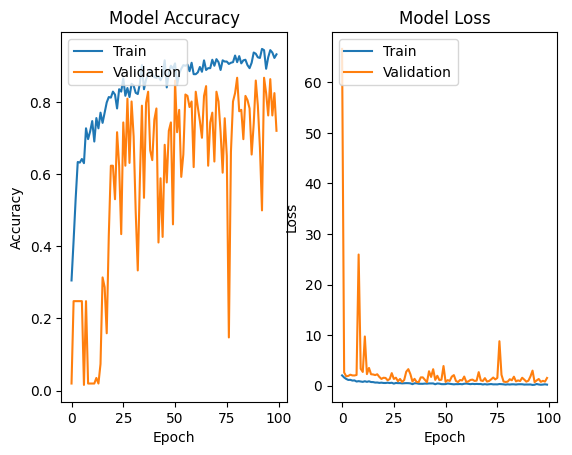

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 가장 낮은 검증 손실을 가진 epoch 찾기
best_epoch = np.argmin(history.history['val_loss'])

# 해당 epoch의 검증 정확도와 손실 출력
best_val_accuracy = history.history['val_accuracy'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]

print("Best Epoch: ", best_epoch + 1)
print("Validation Accuracy at Best Epoch: {:.4f}".format(best_val_accuracy))
print("Validation Loss at Best Epoch: {:.4f}".format(best_val_loss))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 최고 성능 모델 불러오기
best_model = load_model('best_model_resnet_tree.h5')

# 검증 데이터에 대한 예측 수행
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 생성
cm = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 분류 보고서 생성
print(classification_report(y_val, y_pred_classes, target_names=class_names))


9/9 [==============================] - 2s 97ms/step


NameError: name 'class_names' is not defined

<Figure size 800x600 with 0 Axes>

In [12]:
# 평가 시간 측정 및 용량 확인

import time
import os

def get_model_inference_time_and_size(model):
    # 모델 저장
    model_path = 'best_model_resnet_tree'
    model.save(model_path)

    # 모델 파일 크기 확인 (MB 단위)
    model_size = os.path.getsize(model_path) / (1024 * 1024)

    # 추론 시간 측정
    num_samples = 50
    sample_images = random.sample(range(len(X_train)), num_samples)
    start_time = time.time()
    for idx in sample_images:
        _ = model.predict(np.expand_dims(X_train[idx], axis=0))
    end_time = time.time()
    inference_time_per_image = (end_time - start_time) / num_samples

    return model_size, inference_time_per_image

model_size, inference_time = get_model_inference_time_and_size(model)
print(f"Model Size: {model_size:.2f} MB")
print(f"Inference Time per Image: {inference_time * 1000:.2f} ms")


1/1 [==============================] - 0s 23ms/step
Model Size: 0.00 MB
Inference Time per Image: 114.81 ms


1/1 [==============================] - 1s 1s/step


NameError: name 'class_names' is not defined

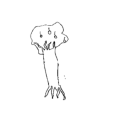

In [13]:
from tensorflow.keras.models import load_model
import random
import numpy as np
import matplotlib.pyplot as plt

# 저장된 최고 성능 모델 불러오기
best_model = load_model('best_model_resnet_tree.h5')

# 50장의 무작위 테스트 이미지 선택
sample_images = random.sample(range(len(X_val)), 50)

correct_count = 0  # 정확하게 분류된 이미지 수

# 추론 및 결과 표시
plt.figure(figsize=(15, 15))
for i, idx in enumerate(sample_images):
    image = X_val[idx]
    true_label = y_val[idx]

    # 이미지 추론
    predicted_probs = best_model.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(predicted_probs)

    # 이미지와 추론 결과 표시
    plt.subplot(10, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    if true_label == predicted_label:
        plt.title(f"Label: {class_names[true_label]}\nCorrect", color='green')
        correct_count += 1
    else:
        plt.title(f"Label: {class_names[true_label]}\nPredicted: {class_names[predicted_label]}", color='red')

plt.tight_layout()
plt.show()

# 정확도 출력
accuracy = (correct_count / len(sample_images)) * 100
print(f"추론 정확도: {accuracy:.2f}%")


In [ ]:
# tf.saved_model.save(model,'240108_2000')

In [ ]:
# model.save('/content/drive/MyDrive/240108_2000.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 최적화

In [ ]:
import os
import re
import subprocess
from pathlib import Path
from typing import List, Optional
import openvino as ov
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm
import nncf
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')
#print('current:', os.getcwd())

ROOT = Path('/content/drive/MyDrive/240108_1800').parent.resolve()
WEIGHTS_URL = "/content/drive/MyDrive/240108_1800.h5"
DATASET_CLASSES = 8


def validate(model: ov.Model, val_loader: tf.data.Dataset) -> tf.Tensor:
    compiled_model = ov.compile_model(model)
    output = compiled_model.outputs[0]

    metric = tf.keras.metrics.CategoricalAccuracy(name="acc@1")
    for images, labels in tqdm(val_loader):
        pred = compiled_model(images.numpy())[output]
        metric.update_state(labels, pred)

    return metric.result()


def run_benchmark(model_path: str, shape: Optional[List[int]] = None, verbose: bool = True) -> float:
    command = f"benchmark_app -m {model_path} -d CPU -api async -t 15"
    if shape is not None:
        command += f' -shape [{",".join(str(x) for x in shape)}]'
    cmd_output = subprocess.check_output(command, shell=True)  # nosec
    if verbose:
        print(*str(cmd_output).split("\\n")[-9:-1], sep="\n")
    match = re.search(r"Throughput\: (.+?) FPS", str(cmd_output))
    return float(match.group(1))


def get_model_size(ir_path: str, m_type: str = "Mb", verbose: bool = True) -> float:
    xml_size = os.path.getsize(ir_path)
    bin_size = os.path.getsize(os.path.splitext(ir_path)[0] + ".bin")
    for t in ["bytes", "Kb", "Mb"]:
        if m_type == t:
            break
        xml_size /= 1024
        bin_size /= 1024
    model_size = xml_size + bin_size
    if verbose:
        print(f"Model graph (xml):   {xml_size:.3f} Mb")
        print(f"Model weights (bin): {bin_size:.3f} Mb")
        print(f"Model size:          {model_size:.3f} Mb")
    return model_size


###############################################################################
# Create a Tensorflow model and dataset


def center_crop(image: tf.Tensor, image_size: int, crop_padding: int) -> tf.Tensor:
    shape = tf.shape(image)
    image_height = shape[0]
    image_width = shape[1]

    padded_center_crop_size = tf.cast(
        ((image_size / (image_size + crop_padding)) * tf.cast(tf.minimum(image_height, image_width), tf.float32)),
        tf.int32,
    )

    offset_height = ((image_height - padded_center_crop_size) + 1) // 2
    offset_width = ((image_width - padded_center_crop_size) + 1) // 2

    image = tf.image.crop_to_bounding_box(
        image,
        offset_height=offset_height,
        offset_width=offset_width,
        target_height=padded_center_crop_size,
        target_width=padded_center_crop_size,
    )

    image = tf.compat.v1.image.resize(
        image, [image_size, image_size], method=tf.image.ResizeMethod.BILINEAR, align_corners=False
    )

    return image


def preprocess_for_eval(image, label):
    image = center_crop(image, 224, 32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    label = tf.one_hot(label, DATASET_CLASSES)

    return image, label




val_dataset = tfds.load("imagenette/320px-v2", split="validation", shuffle_files=False, as_supervised=True)
val_dataset = val_dataset.map(preprocess_for_eval).batch(128)

weights_path = tf.keras.utils.get_file("/content/drive/MyDrive/240108_1800_model", WEIGHTS_URL, cache_subdir="models")
tf_model = tf.keras.applications.MobileNetV2(weights=weights_path, classes=DATASET_CLASSES)

###############################################################################
# Quantize a Tensorflow model
#
# The transformation function transforms a data item into model input data.
#
# To validate the transform function use the following code:
# >> for data_item in val_loader:
# >>    model(transform_fn(data_item))


# def transform_fn(data_item):
#     images, _ = data_item
#     return images


# # The calibration dataset is a small, no label, representative dataset
# # (~100-500 samples) that is used to estimate the range, i.e. (min, max) of all
# # floating point activation tensors in the model, to initialize the quantization
# # parameters.
# #a
# # The easiest way to define a calibration dataset is to use a training or
# # validation dataset and a transformation function to remove labels from the data
# # item and prepare model input data. The quantize method uses a small subset
# # (default: 300 samples) of the calibration dataset.

# calibration_dataset = nncf.Dataset(val_dataset, transform_fn)
# tf_quantized_model = nncf.quantize(tf_model, calibration_dataset)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: unknown url type: '/content/drive/MyDrive/240108_1800.h5'

In [ ]:
# Quantize a Tensorflow model
#
# The transformation function transforms a data item into model input data.
#
# To validate the transform function use the following code:
# >> for data_item in val_loader:
# >>    model(transform_fn(data_item))


def transform_fn(data_item):
    images, _ = data_item
    return images


# The calibration dataset is a small, no label, representative dataset
# (~100-500 samples) that is used to estimate the range, i.e. (min, max) of all
# floating point activation tensors in the model, to initialize the quantization
# parameters.
#
# The easiest way to define a calibration dataset is to use a training or
# validation dataset and a transformation function to remove labels from the data
# item and prepare model input data. The quantize method uses a small subset
# (default: 300 samples) of the calibration dataset.

calibration_dataset = nncf.Dataset(val_dataset, transform_fn)
tf_quantized_model = nncf.quantize(tf_model, calibration_dataset)

###############################################################################
# Benchmark performance, calculate compression rate and validate accuracy

ov_model = ov.convert_model(tf_model, share_weights=False)
#경량화 모델 : ov_quntized_model
ov_quantized_model = ov.convert_model(tf_quantized_model, share_weights=False)

fp32_ir_path = f"{ROOT}/mobilenet_v2_fp32.xml"
ov.save_model(ov_model, fp32_ir_path, compress_to_fp16=False)
print(f"[1/7] Save FP32 model: {fp32_ir_path}")
fp32_model_size = get_model_size(fp32_ir_path, verbose=True)

int8_ir_path = f"{ROOT}/mobilenet_v2_int8.xml"
ov.save_model(ov_quantized_model, int8_ir_path, compress_to_fp16=False)
print(f"[2/7] Save INT8 model: {int8_ir_path}")
int8_model_size = get_model_size(int8_ir_path, verbose=True)

print("[3/7] Benchmark FP32 model:")
fp32_fps = run_benchmark(fp32_ir_path, shape=[1, 224, 224, 3], verbose=True)
print("[4/7] Benchmark INT8 model:")
int8_fps = run_benchmark(int8_ir_path, shape=[1, 224, 224, 3], verbose=True)

print("[5/7] Validate OpenVINO FP32 model:")
fp32_top1 = validate(ov_model, val_dataset)
print(f"Accuracy @ top1: {fp32_top1:.3f}")

print("[6/7] Validate OpenVINO INT8 model:")
int8_top1 = validate(ov_quantized_model, val_dataset)
print(f"Accuracy @ top1: {int8_top1:.3f}")

print("[7/7] Report:")
print(f"Accuracy drop: {fp32_top1 - int8_top1:.3f}")
print(f"Model compression rate: {fp32_model_size / int8_model_size:.3f}")
# https://docs.openvino.ai/latest/openvino_docs_optimization_guide_dldt_optimization_guide.html
print(f"Performance speed up (throughput mode): {int8_fps / fp32_fps:.3f}")

INFO:nncf:Creating compression algorithm: quantization
INFO:nncf:Overflow issue fix was applied to first convolution weight quantizers.
INFO:nncf:Collecting tensor statistics/data |█████           | 1 / 3
INFO:nncf:Collecting tensor statistics/data |██████████      | 2 / 3
INFO:nncf:Collecting tensor statistics/data |████████████████| 3 / 3
INFO:nncf:BatchNorm statistics adaptation |█████           | 1 / 3
INFO:nncf:BatchNorm statistics adaptation |██████████      | 2 / 3
INFO:nncf:BatchNorm statistics adaptation |████████████████| 3 / 3
[1/7] Save FP32 model: /content/drive/MyDrive/mobilenet_v2_fp32.xml
Model graph (xml):   0.079 Mb
Model weights (bin): 8.397 Mb
Model size:          8.476 Mb
[2/7] Save INT8 model: /content/drive/MyDrive/mobilenet_v2_int8.xml
Model graph (xml):   0.397 Mb
Model weights (bin): 2.242 Mb
Model size:          2.639 Mb
[3/7] Benchmark FP32 model:
[ INFO ] Count:            1452 iterations
[ INFO ] Duration:         15035.20 ms
[ INFO ] Latency:
[ INFO ]    

100%|██████████| 31/31 [01:21<00:00,  2.65s/it]


Accuracy @ top1: 0.198
[6/7] Validate OpenVINO INT8 model:


100%|██████████| 31/31 [01:21<00:00,  2.64s/it]

Accuracy @ top1: 0.198
[7/7] Report:
Accuracy drop: 0.000
Model compression rate: 3.211
Performance speed up (throughput mode): 1.143


INFO:nncf:Creating compression algorithm: quantization
INFO:nncf:Overflow issue fix was applied to first convolution weight quantizers.
INFO:nncf:Collecting tensor statistics/data |█████           | 1 / 3
INFO:nncf:Collecting tensor statistics/data |██████████      | 2 / 3
INFO:nncf:Collecting tensor statistics/data |████████████████| 3 / 3
INFO:nncf:BatchNorm statistics adaptation |█████           | 1 / 3
INFO:nncf:BatchNorm statistics adaptation |██████████      | 2 / 3
INFO:nncf:BatchNorm statistics adaptation |████████████████| 3 / 3
[1/7] Save FP32 model: /content/drive/MyDrive/mobilenet_v2_fp32.xml
Model graph (xml):   0.079 Mb
Model weights (bin): 8.397 Mb
Model size:          8.476 Mb
[2/7] Save INT8 model: /content/drive/MyDrive/mobilenet_v2_int8.xml
Model graph (xml):   0.397 Mb
Model weights (bin): 2.242 Mb
Model size:          2.639 Mb
[3/7] Benchmark FP32 model:
[ INFO ] Count:            1302 iterations
[ INFO ] Duration:         15035.50 ms
[ INFO ] Latency:
[ INFO ]    

100%|██████████| 31/31 [01:22<00:00,  2.65s/it]


Accuracy @ top1: 0.198
[6/7] Validate OpenVINO INT8 model:


100%|██████████| 31/31 [00:53<00:00,  1.72s/it]

Accuracy @ top1: 0.198
[7/7] Report:
Accuracy drop: 0.000
Model compression rate: 3.211
Performance speed up (throughput mode): 1.253


In [ ]:
|